# ELE510 Image Processing with robot vision: LAB, Exercise 6, Image features detection.

**Purpose:** *To learn about the edges and corners features detection, and their descriptors.*

The theory for this exercise can be found in chapter 7 of the text book [1] and in appendix C in the compendium [2]. See also the following documentations for help:
- [OpenCV](https://opencv.org/opencv-python-free-course/)
- [numpy](https://numpy.org/doc/stable/)
- [matplotlib](https://matplotlib.org/stable/contents.html)
- [scipy](https://docs.scipy.org/doc/)


**IMPORTANT:** Read the text carefully before starting the work. In
many cases it is necessary to do some preparations before you start the work
on the computer. Read necessary theory and answer the theoretical part
first. The theoretical and experimental part should be solved individually.
The notebook must be approved by the lecturer or his assistant.

**Approval:**
<div class="alert alert-block alert-success">
The current notebook should be submitted on CANVAS as a single pdf file. 
</div>

<div class="alert alert-block alert-info">
    To export the notebook in a pdf format, goes to File -> Download as -> PDF via LaTeX (.pdf).
</div>

**Note regarding the notebook**: The theoretical questions can be answered directly on the notebook using a *Markdown* cell and LaTex commands (if relevant). In alternative, you can attach a scan (or an image) of the answer directly in the cell.

Possible ways to insert an image in the markdown cell:

`![image name]("image_path")`

`<img src="image_path" alt="Alt text" title="Title text" />`


**Under you will find parts of the solution that is already programmed.**

<div class="alert alert-block alert-info">
    <p>You have to fill out code everywhere it is indicated with `...`</p>
    <p>The code section under `######## a)` is answering subproblem a) etc.</p>
</div>

## Problem 1

**Intensity edges** are pixels in the image where the intensity (or graylevel) function changes rapidly.

The **Canny edge detector** is a classic algorithm for detecting intensity edges in a grayscale image that relies on the gradient magnitude. The algorithm was developed by John F. Canny in 1986. It is a multi-stage algorithm that provides good and reliable detection.

**a)** Create the **Canny algorithm**, described at pag. 336 (alg. 7.1). For the last step (`EDGELINKING`) you can either use the algorithm 7.3 at page 338 or the `HYSTERESIS THRESHOLD` algorithm 10.3 described at page 451.
All the following images are taken from the text book [1].

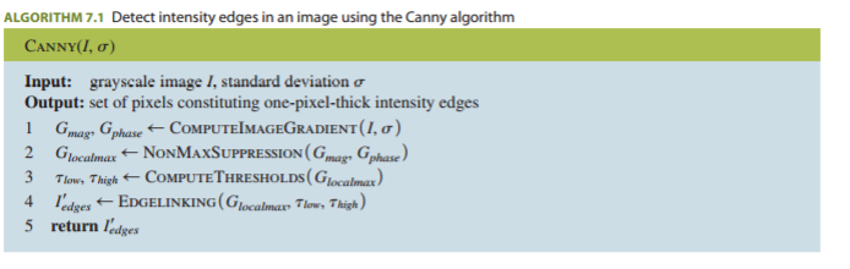

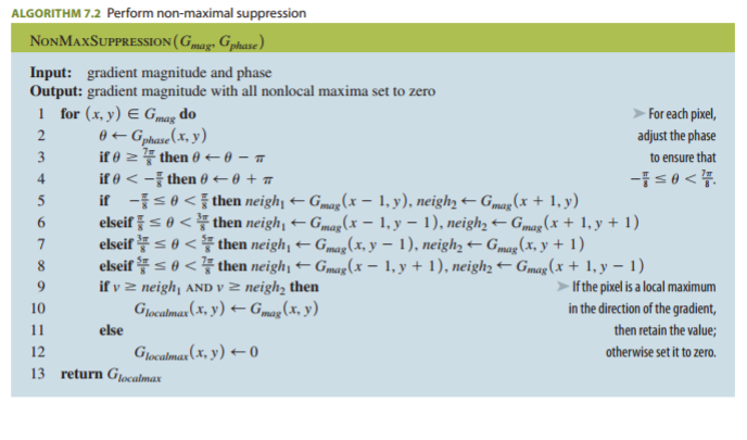

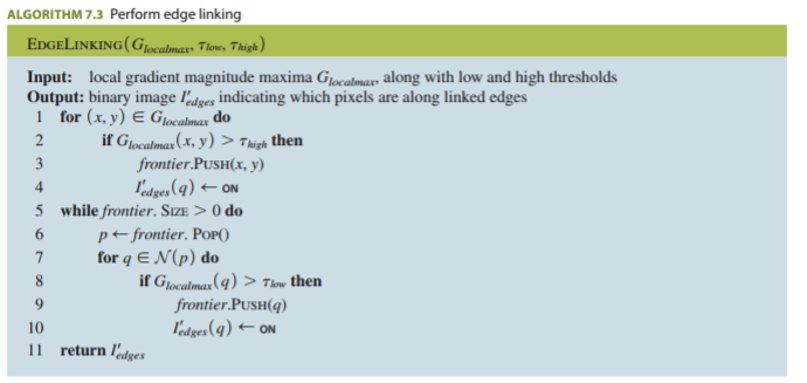

**Remember:**

- Sigma (second parameter in the Canny algorithm) is not necessary for the calculation since the Sobel operator (in opencv) combines the Gaussian smoothing and differentiation, so the results is nore or less resistant to the noise. 
- We are defining the low and high thresholds manually in order to have a better comparison with the predefined opencv function. It is possible to extract the low and high thresholds automatically from the image but it is not required in this problem.

**b)** Test your algorithm with a image of your choice and compare your results with the predefined function in opencv: 

```python
cv2.Canny(img, t_low, t_high, L2gradient=True)
``` 
[Documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny).

### P.S. : 
<div class="alert alert-block alert-info">
The goal of this problem it is not to create a **perfect** replication of the algorithm in opencv, but to understand the various steps involved and to be able to extract the edges from an ima ge using these steps.
</div>

In [1]:
import cv2
import numpy as np

# Sobel operator to find the first derivate in the horizontal and vertical directions
def computeImageGradient(Im):
    # Sobel operator  to find the first derivate in the horizontal and vertical directions
    
    ## TODO: The default ksize is 3, try different values and comment the result
    g_x = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    g_y = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    
    ############################
    # Calculate the magnitude and the gradient direction like it is performed during the assignment 4 (problem 2a)
    G_mag = np.sqrt(g_x**2 + g_y**2)
    G_phase = np.arctan2(g_y, g_x)
    
    return G_mag, G_phase

In [2]:
# NonMaxSuppression algorithm 
def nonMaxSuppression(G_mag, G_phase):
    G_localmax = np.zeros((G_mag.shape))
    
    # For each pixel, adjust the phase to ensure that -pi/8 <= theta < 7*pi/8
    for i in range(1, G_mag.shape[0]-1):
        for j in range(1, G_mag.shape[1]-1):
            theta = G_phase[i, j]

            if theta > 7*np.pi/8:
                theta -= np.pi
            if theta < -np.pi/8:
                theta += np.pi

            neigh_1 = 0
            neigh_2 = 0

            if -np.pi/8 <= theta < np.pi/8:
                neigh_1 = G_mag[i-1, j]
                neigh_2 = G_mag[i+1, j]
            elif np.pi/8 <= theta < 3*np.pi/8:
                neigh_1 = G_mag[i-1, j-1]
                neigh_2 = G_mag[i+1, j+1]
            elif 3*np.pi/8 <= theta < 5*np.pi/8:
                neigh_1 = G_mag[i, j-1]
                neigh_2 = G_mag[i, j+1]
            elif 5*np.pi/8 <= theta < 7*np.pi/8:
                neigh_1 = G_mag[i-1, j+1]
                neigh_2 = G_mag[i+1, j-1]
            
            # If the current pixel is greater than its neighbors, it is a local maximum
            if G_mag[i, j] >= neigh_1 and G_mag[i, j] >= neigh_2:
                G_localmax[i, j] = G_mag[i, j]
    
    return G_localmax

In [3]:
def N(p, max_x, max_y):
    N_P = list()
    if p[0] > 0:
        N_P.append((p[0]-1, p[1]))
        if p[1] > 0:
            N_P.append((p[0]-1, p[1]-1))
        if p[1] < max_y:
            N_P.append((p[0]-1, p[1]+1))
    if p[0] < max_x:
        N_P.append((p[0]+1, p[1]))
        if p[1] > 0:
            N_P.append((p[0]+1, p[1]-1))
        if p[1] < max_y:
            N_P.append((p[0]+1, p[1]+1))
    if p[1] > 0:
        N_P.append((p[0], p[1]-1))
    if p[1] < max_y:
        N_P.append((p[0], p[1]+1))
    return N_P

def edgeLinking(G_localmax, t_low, t_high):
    I_edges = np.zeros((G_localmax.shape))
    
    l = list()
    # Set the threshold image and perform edge linking (or hysteresis thresholding)
    for i in range(G_localmax.shape[0]):
        for j in range(G_localmax.shape[0]):
            if G_localmax[i, j] >= t_high:
                I_edges[i, j] = 255
                l.append((i, j))
    
    while len(l) > 0:
        p = l.pop()
        for q in N(p, max_x=I_edges.shape[0]-1, max_y=I_edges.shape[1]-1):
            if G_localmax[q[0], q[1]] >= t_low and I_edges[q[0], q[1]] == 0:
                I_edges[q[0], q[1]] = 255
                l.append(q)
    return I_edges

In [4]:
import matplotlib.pyplot as plt

"""
Function that performs the Canny algorithm.

The entire cell is locked, thus you can only test the function and NOT change it!

Input: 
    - Im: image in grayscale
    - t_low: first threshold for the hysteresis procedure (edge linking)
    - t_high: second threshold for the hysteresis procedure (edge linking)
"""
def my_cannyAlgorithm(Im, t_low, t_high):
    ## Compute the image gradient 
    G_mag, G_phase = computeImageGradient(Im)
    
    ## NonMaxSuppression algorithm 
    G_localmax = nonMaxSuppression(G_mag, G_phase)
        
    ## Edge linking
    if t_low>t_high: t_low, t_high = t_high, t_low
    I_edges = edgeLinking(G_localmax, t_low, t_high)
    
    plt.figure(figsize=(30,30))
    plt.subplot(141), plt.imshow(G_mag, cmap='gray')
    plt.title('Magnitude image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(G_phase, cmap='gray')
    plt.title('Phase image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(G_localmax, cmap='gray')
    plt.title('After non maximum suppression.'), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(I_edges, cmap='gray')
    plt.title('Threshold image.'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return I_edges

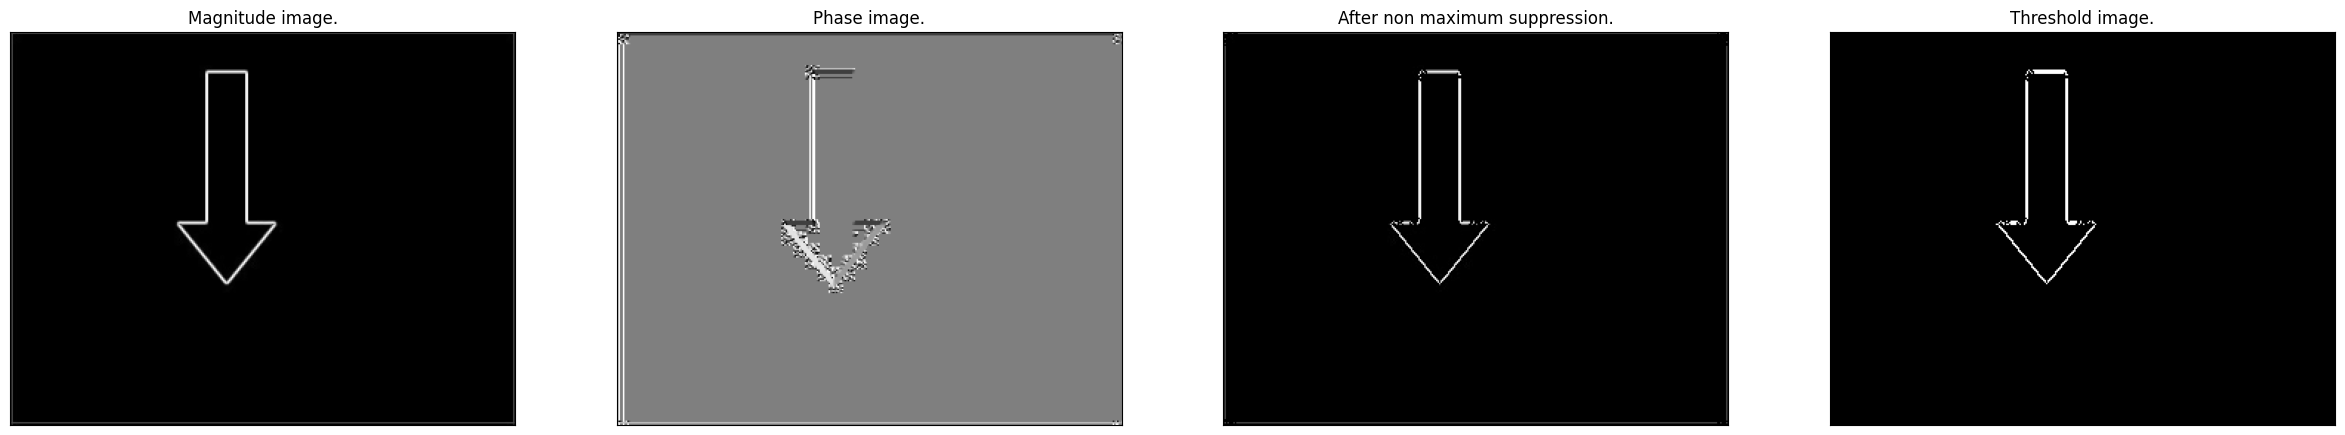

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

Im = cv2.imread("images/arrow_1.jpg", cv2.IMREAD_GRAYSCALE)

t_low = 100
t_high = 250
I_edges = my_cannyAlgorithm(Im, t_low, t_high)


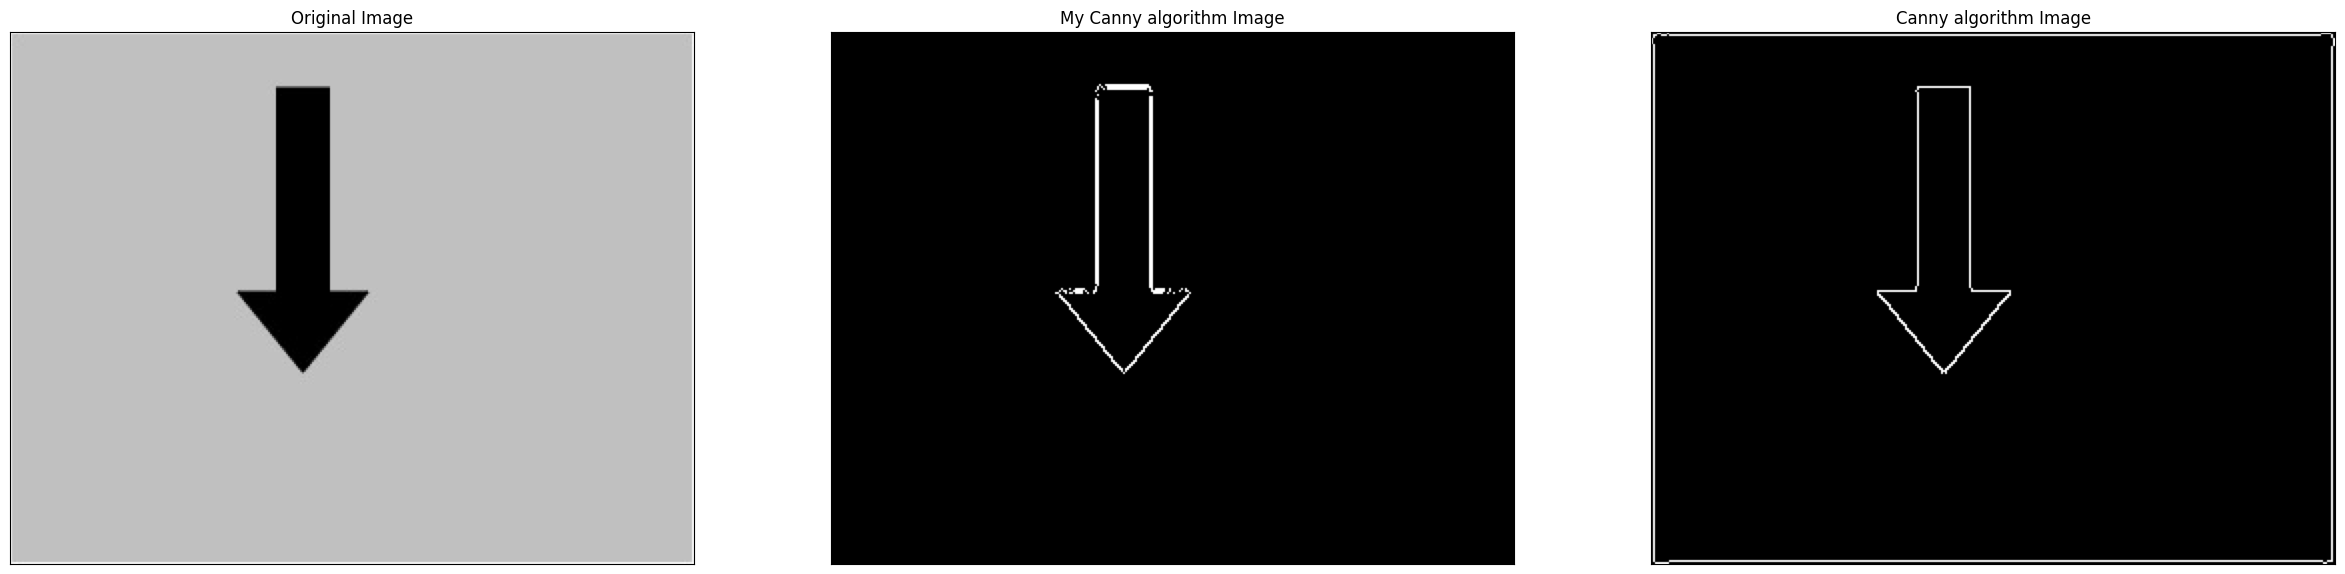

In [6]:
# LOCKED cell: useful to check and visualize the results.

plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(Im, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(I_edges, cmap='gray')
plt.title('My Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(cv2.Canny(Im,t_low, t_high, L2gradient=False), cmap='gray')
plt.title('Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Problem 2

One of the most popular approaches to feature detection is the **Harris corner detector**, after a work of Chris Harris and Mike Stephens from 1988.

**a)** Use the function in opencv `cv2.cornerHarris(...)` ([Documentation](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)) with `blockSize=3, ksize=3, k=0.04` with the **./images/chessboard.png** image to detect the corners (you can find the image on CANVAS).

**b)** Plot the image with the detected corners found.

**Hint**: Use the function `cv2.drawMarker(...)` ([Documentation](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#ga644c4a170d4799a56b29f864ce984b7e)) to show the corners in the image.

**c)** Detect the corners using the images **./images/arrow_1.jpg**, **./images/arrow_2.jpg** and **./images/arrow_3.jpg**; describe and compare the results in the three images.

**d)** What happen if you change (increase/decrease) the `k` constant for the "corner points"? 


K=0.04


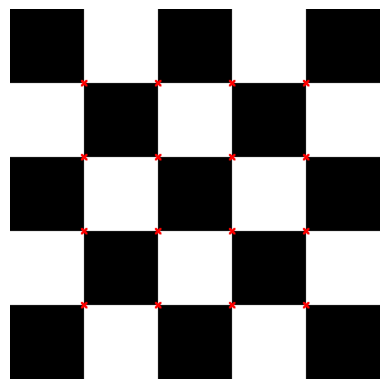

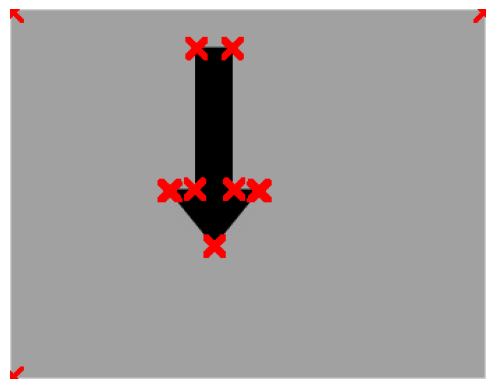

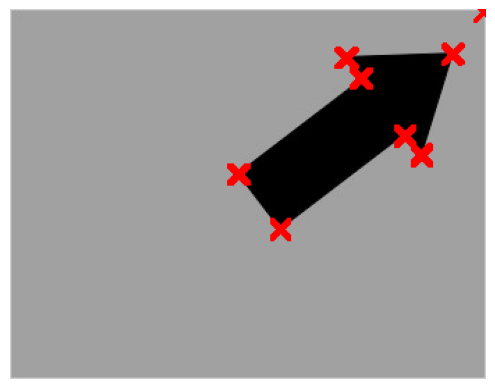

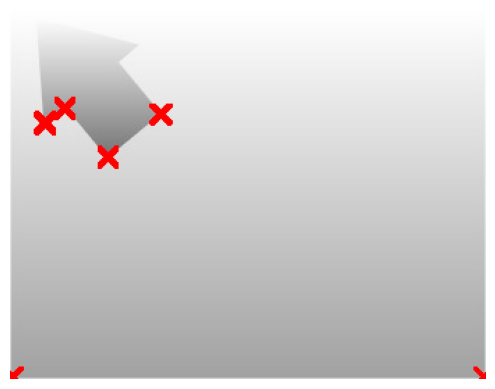

K=0.001


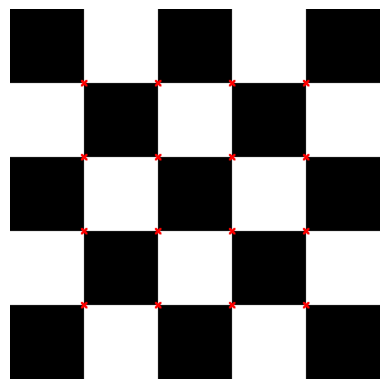

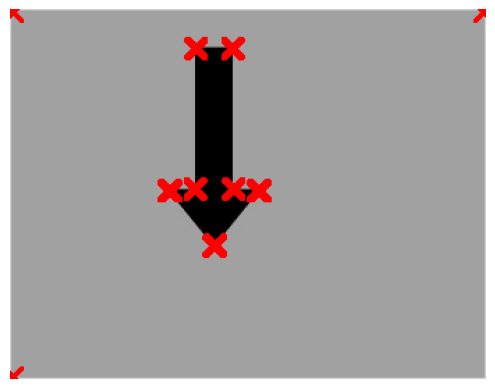

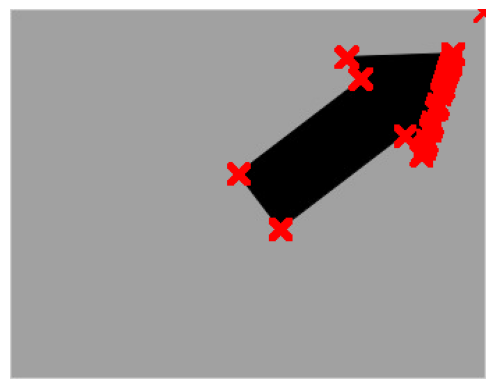

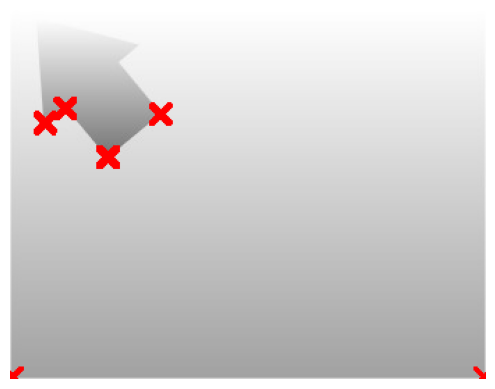

K=0.2


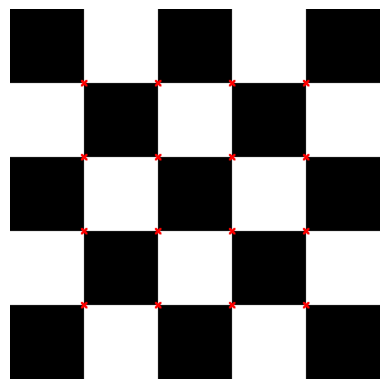

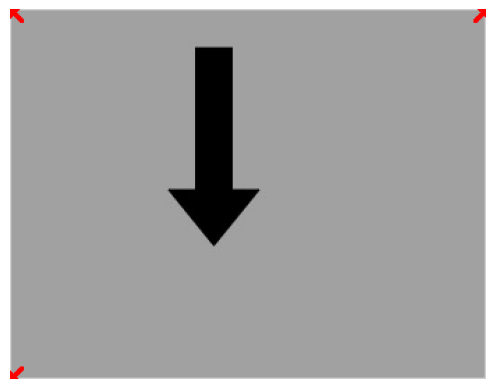

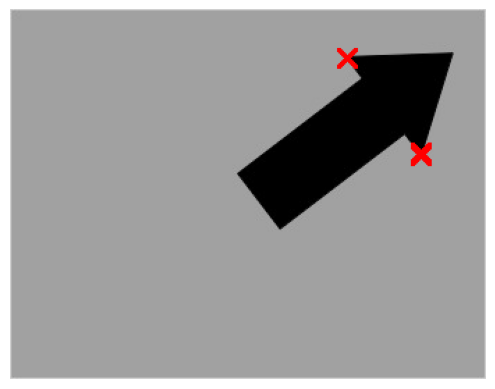

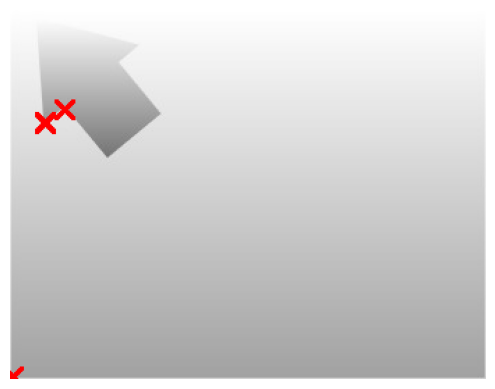

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def draw_corner_image(Img, k=0.04):
    # Use the Corner Harris method to detect corners
    dst = cv2.cornerHarris(Img, blockSize=2, ksize=3, k=k)
    dst = cv2.dilate(dst, None)
    
    Img_colored = cv2.cvtColor(Img, cv2.COLOR_GRAY2BGR)

    # Threshold to keep only significant corner responses
    thresh = 0.01 * dst.max()

    # Iterate through each corner and draw markers on those locations
    for i in range(0, dst.shape[0]):
        for j in range(0, dst.shape[1]):
            if dst[i,j] > thresh:
                cv2.drawMarker(Img_colored, (j, i), (0, 0, 255), markerType=cv2.MARKER_TILTED_CROSS, markerSize=12, thickness=1)

    # Display the image with detected corners using matplotlib
    plt.imshow(cv2.cvtColor(Img_colored, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


print("K=0.04")
Img = cv2.imread("images/chessboard.png", cv2.IMREAD_GRAYSCALE)
# shrink the image to half its size
Img = cv2.resize(Img, (0,0), fx=0.5, fy=0.5)
draw_corner_image(Img)
Img = cv2.imread("images/arrow_1.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img)
Img = cv2.imread("images/arrow_2.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img)
Img = cv2.imread("images/arrow_3.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img)


print("K=0.001")
Img = cv2.imread("images/chessboard.png", cv2.IMREAD_GRAYSCALE)
# shrink the image to half its size
Img = cv2.resize(Img, (0,0), fx=0.5, fy=0.5)
draw_corner_image(Img, k=0.001)
Img = cv2.imread("images/arrow_1.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img, k=0.001)
Img = cv2.imread("images/arrow_2.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img, k=0.001)
Img = cv2.imread("images/arrow_3.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img, k=0.001)


print("K=0.2")
Img = cv2.imread("images/chessboard.png", cv2.IMREAD_GRAYSCALE)
# shrink the image to half its size
Img = cv2.resize(Img, (0,0), fx=0.5, fy=0.5)
draw_corner_image(Img, k=0.2)
Img = cv2.imread("images/arrow_1.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img, k=0.2)
Img = cv2.imread("images/arrow_2.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img, k=0.2)
Img = cv2.imread("images/arrow_3.jpg", cv2.IMREAD_GRAYSCALE)
draw_corner_image(Img, k=0.2)

When increasing the k, we can see that the detected corners are becoming more accurate in their location (indicated by smaller red areas / fewer markers at a single corner), but not all corners are being found. If we decrease the k, not only do we see the opposite, but we can also observe that false corners are being detected along diagonals due do aliasing of sharp edges in the image.

Nevertheless, in any k the edges in the checkerboard image are being accuratley detected (have to shrink image / make markers a lot bigger to see corner markers due to large image dimensions).

# Problem 3 

**a)** What is the SIFT approach? Describe the steps involved.

**b)** Why this approach is more popular than the Harris detector?

**c)** Explain the difference between a feature detector and a feature descriptor.

#### Answers

**a)**
**S**cale-**I**nvariant **F**eature **T**ransform is a technique used for detecting and describing local features in images. It involves the following steps:
1. The first step is to construct a scale space
2. Thereafter approximate a Laplacian pyramid of the image using DoG using the scale space
images.
3. Determine, for every pixel and for every scale, whether the pixel is a local maximum
among its 26 neighbors. ( 8 in same scale, 9 in neighbor larger scale, 9 from neighbor
smaller scale)
4. Discard bad key-points, i.e. untextured areas or along intensity edges. The Hessian is found from the DoG images
already calculated:
	 - Discard keypoints with low DoG value (low contrast)
	 - Discard keypoints on edges based on finding “edgeness” from the Hessian matrix

**b)**
A main advantage of SIFT over Harris corner detector is that SIFT is scale invariant, i.e. it can find a edge regardless of how large or small the image dimensions are.
This has a great implication: If we have the SIFT feature description of one object, we can easily detect that object in another image, even if the object is not only rotated and translated, but even scaled differently in the new image.

**c)**
- Feature Detector: It identifies interest points or features in an image, such as corners, blobs, or edges.
 - Feature Descriptor: Once features are detected, a descriptor captures and describes the local appearance around those features, generating a vector that acts as a unique signature for each feature. This helps in matching features across different images.


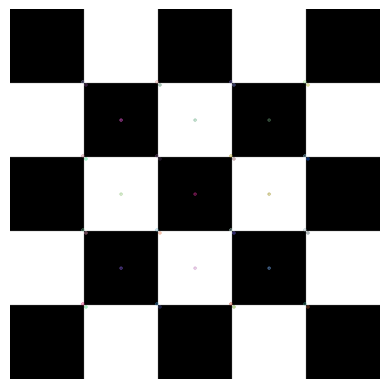

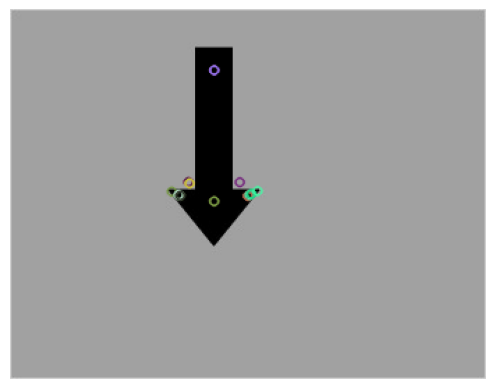

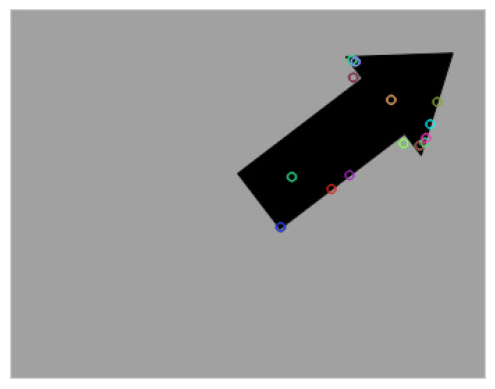

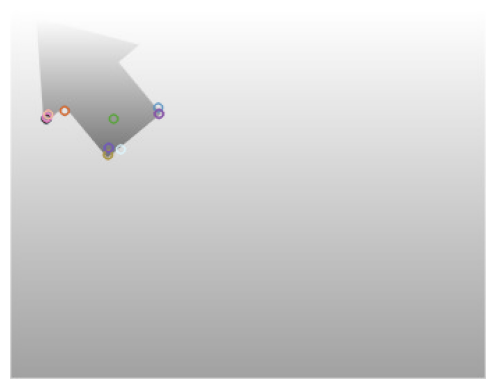

In [8]:
# Just for me:

import cv2
import matplotlib.pyplot as plt


def draw_corner_image(Img):
    gray = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp = sift.detect(gray,None)
    
    Img_colored = cv2.drawKeypoints(gray,kp,Img)
    
    # Display the image with detected corners using matplotlib
    plt.imshow(cv2.cvtColor(Img_colored, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


Img = cv2.imread("images/chessboard.png")
# shrink the image to half its size
Img = cv2.resize(Img, (0,0), fx=0.5, fy=0.5)
draw_corner_image(Img)
Img = cv2.imread("images/arrow_1.jpg")
draw_corner_image(Img)
Img = cv2.imread("images/arrow_2.jpg")
draw_corner_image(Img)
Img = cv2.imread("images/arrow_3.jpg")
draw_corner_image(Img)


### Delivery (dead line) on CANVAS: 13.10.2023 at 23:59


## Contact
### Course teacher
Professor Kjersti Engan, room E-431,
E-mail: kjersti.engan@uis.no

### Teaching assistant
Saul Fuster Navarro, room E-401
E-mail: saul.fusternavarro@uis.no


Jorge Garcia Torres Fernandez, room E-401
E-mail: jorge.garcia-torres@uis.no


## References

[1] S. Birchfeld, Image Processing and Analysis. Cengage Learning, 2016.

[2] I. Austvoll, "Machine/robot vision part I," University of Stavanger, 2018. Compendium, CANVAS.